Przyczynowość i jej wykrywanie
---------------
*Wiktor Soral 15.06.2016*

Wyobraźmy sobie 2 zmienne pozostające ze sobą w pewnej zależności. Prosty wykres rozrzutu pozwoli nam zobrazować tą zależność.

$y = 2 + 0.5x - 0.1x^2 + 0.01x^3 + e$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm
%matplotlib notebook
import matplotlib as mpl
import pystan
import hsic

In [15]:
x = np.random.uniform(0,10,200)
e = np.random.normal(0,1, 200)
def zaleznosc(exog):
    return 2 + 0.5*exog - 0.1*exog**2 + 0.01*exog**3
y = zaleznosc(x) + e

<IPython.core.display.Javascript object>


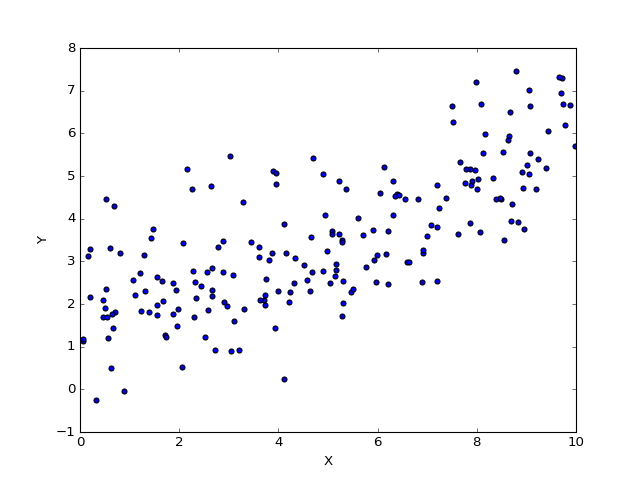

(0, 10)

In [3]:
plt.scatter(x,y)
plt.xlabel("X");plt.ylabel("Y");plt.xlim(0,10)

Oczywiście taki wykres rozrzutu nie mówi nam nic o charakterze przyczynowym relacji pomiędzy tymi zmiennymi. Zakładając jednak, że prawdziwe jest jedno z 2:
- X --> Y
- Y --> X

możemy oczekiwać pewnej asymetrii w rozkładzie obu zmiennych. Wynika to z faktu, że:

$y = f(x) + \epsilon$

gdzie

$\epsilon \sim N(0,\sigma)$

In [4]:
def probability(x,y,sd):
    mu = zaleznosc(y)
    dist = norm(loc = mu, scale = sd)
    return dist.pdf(x)

X = np.r_[0:10:100j]
Y = np.r_[0:10:100j]
xx, yy  = np.mgrid[0:10:100j, 0:10:100j]
Z = probability(xx,yy,1)

<IPython.core.display.Javascript object>


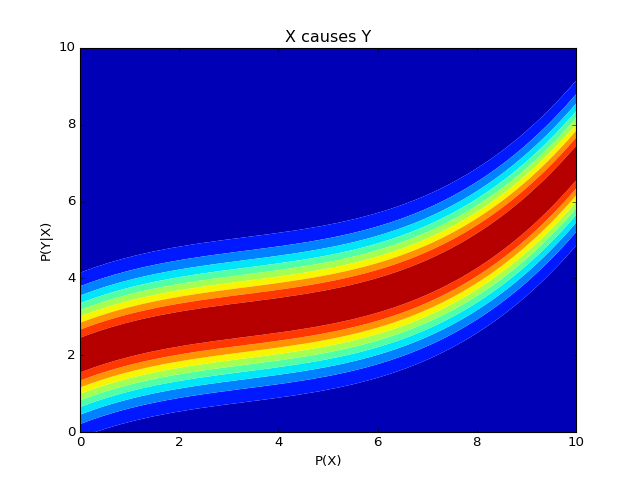

In [5]:
CS = plt.contourf(X,Y,Z, 10, antialiased= True)
plt.xlabel("P(X)"); plt.ylabel("P(Y|X)"); plt.title("X causes Y")

In [6]:
def probability2(x,y,sd):
    mu = zaleznosc(y)
    dist = norm(loc = mu, scale = np.exp(np.abs(y-5)*0.1*sd))
    return dist.pdf(x)

Z2 = probability2(xx,yy,1)

<IPython.core.display.Javascript object>


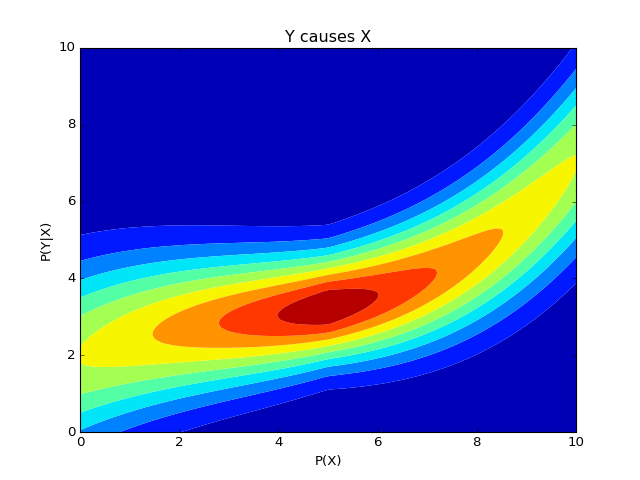

In [7]:
plt.contourf(X,Y,Z2, 10, antialiased= True)
plt.xlabel("P(X)");plt.ylabel("P(Y|X)");plt.title("Y causes X")

In [16]:
idx = np.random.randint(0,len(x)-1, int(len(x)/2))
x_train = x[idx]
x_test = x[-idx]
y_train = y[idx]
y_test = y[-idx]

In [17]:
x.shape

(200,)

In [9]:
fit = pystan.StanModel(file="gaussianProcess.stan")

In [37]:
datXcY = {'x1':x_train,'x2':x_test,'y1':y_train,'N1':len(x_train), 'N2':len(x_test)}
#outXcY = pystan.sampling(data = datXcY, iter = 500)
outXcY = fit.optimizing(data = datXcY)

<IPython.core.display.Javascript object>


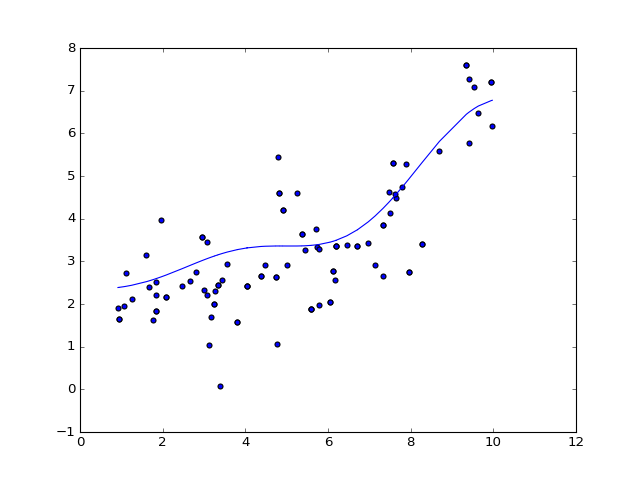

In [25]:
plt.scatter(x_test, y_test)
plt.plot(x_test[np.argsort(x_test)], outXcY['y2'][np.argsort(x_test)])

In [38]:
resXcY = hsic.hsicTestGamma(x_test, (y_test - outXcY['y2']))

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/matlib.py:92: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = ndarray.__new__(matrix, shape, dtype, order=order)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/lib/twodim_base.py:233: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  m = zeros((N, M), dtype=dtype)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/lib/twodim_base.py:240: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  m[:M-k].flat[i::M+1] = 1


<IPython.core.display.Javascript object>


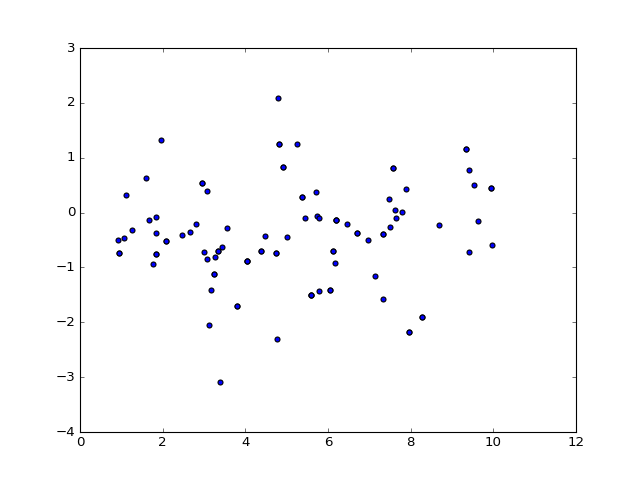

In [45]:
plt.scatter(x_test, (y_test - outXcY['y2']))

In [40]:
resXcY

{'mHSIC': matrix([[ 0.00399085]]),
 'testStat': 2.6307334181528119e-06,
 'treshold': array([[  2.43561483e+10]]),
 'varHSIC': 6.5392315895080416e-16}

In [41]:
datYcX = {'x1':y_train,'x2':y_test,'y1':x_train,'N1':len(x_train), 'N2':len(x_test)}
#outYcX = pystan.sampling(data = datYcX, iter = 500)
outYcX = fit.optimizing(data = datYcX)

In [42]:
resYcX = hsic.hsicTestGamma(y_test, (x_test - outYcX['y2']))
resYcX

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/matlib.py:92: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = ndarray.__new__(matrix, shape, dtype, order=order)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/lib/twodim_base.py:233: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  m = zeros((N, M), dtype=dtype)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/lib/twodim_base.py:240: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  m[:M-k].flat[i::M+1] = 1


{'mHSIC': matrix([[ 0.00330097]]),
 'testStat': 6.8531167900807258e-07,
 'treshold': array([[  2.11175260e+12]]),
 'varHSIC': 5.159889523088439e-18}

<IPython.core.display.Javascript object>


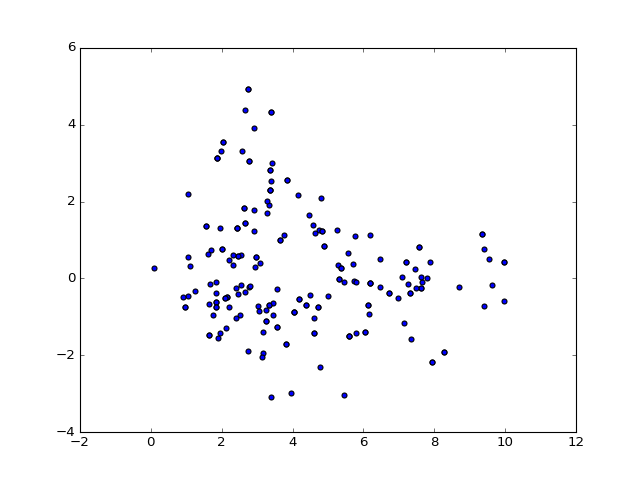

In [43]:
plt.scatter(y_test, (x_test - outYcX['y2']))